In [1]:
# https://www.tensorflow.org/install/source#gpu
! nvcc  --version

import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
import tensorflow_datasets as tfds

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

from src.utils import polar_transform, polar_transform_inv, apply_circular_mask

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


2024-02-19 21:10:45.381631: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 21:10:45.381709: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 21:10:45.381741: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-19 21:10:45.388537: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


/project/johannsc/symmetries/RadialBeams/venv/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
2024-02-19 21:10:50.667275: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-02-19 21:10:50.668791: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43606 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:04:00.0, comput

In [2]:
import wandb
from datetime import datetime

dataset_name = 'stanford_dogs'
image_size = 100
batch_size = 256
n_epochs = 10
n_channels = 3
n_classes = 1000

# strategy = tf.distribute.MirroredStrategy()

# see polar_transform
# radius = 1/2 * sqrt(W^2 + H^2)
# this is the computation to keep all HxW pixels inside the radius? but we use circular masking 
radius = image_size//2#(np.array([image_size, image_size])**2).sum()**0.5/2
len_beam = int(round(radius))
n_beams = int(round(radius*2*np.pi))
print(len_beam, n_beams)

config = {
}

wandb.init(project="RadialBeams", config=config, group=dataset_name, name=datetime.now().strftime("%m%d-%H%M"))

50 314


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: johschm. Use `wandb login --relogin` to force relogin


In [3]:
# plt.rcParams["image.cmap"] = "gray"

train_dataset = tfds.load(dataset_name, split='train', shuffle_files=False)
test_dataset = tfds.load(dataset_name, split='test', shuffle_files=False)

def preprocess(example):
    image = tf.cast(example['image'], tf.float32) / 255.
    image = tf.image.resize(image, [image_size, image_size])
    image = apply_circular_mask(image)
    return {
        'image': image,
        'label': example['label'],
        'polar': polar_transform(image, radius=radius)
    }

train_dataset = train_dataset.map(preprocess).batch(batch_size)
test_dataset = test_dataset.map(preprocess).batch(batch_size)

next(iter(train_dataset))['polar'].shape

TensorShape([256, 50, 314, 3])

In [18]:
from tensorflow.keras import layers, models

def cyclic_beam_padding(x, padding=1):
    return tf.concat([x[:, :, x.shape[2]-padding:], x, x[:, :, :padding]], axis=-2)
    
class PolarRegressor(tf.keras.Model):
    def __init__(self):
        super().__init__()
        # padding such that kernels of size 3 on the edges use cyclic padded values
        # padding = kernel_size - 1 using "same" padding
        self.padding = 1
        self.encoder = models.Sequential([
            layers.InputLayer(input_shape=(len_beam, n_beams+2*self.padding, n_channels)),

            layers.Conv2D(16, (3, 3), activation='gelu', padding='same'),
            layers.Conv2D(32, (3, 3), activation='gelu', padding='same'),
            layers.LayerNormalization(),
            
            layers.Conv2D(64, (3, 3), activation='gelu', padding='same'),
            layers.Conv2D(64, (3, 3), activation='gelu', padding='same'),
            layers.LayerNormalization(),

            layers.Conv2D(32, (3, 3), activation='gelu', padding='same'),
            layers.Conv2D(8, (3, 3), activation='gelu', padding='same'),
            layers.LayerNormalization(),
        ])
        self.encoder2 = models.Sequential([
            layers.InputLayer(input_shape=(n_beams, 400)),
            layers.Dense(64, activation='gelu'),
            layers.Dense(1),
            layers.Flatten()
        ])
    
    def call(self, x, output_conv_features=False):
        if self.padding > 0:
            x = cyclic_beam_padding(x, padding=self.padding)
        z_conv = self.encoder(x)
        z = tf.transpose(z_conv, (0, 2, 1, 3))
        z = tf.reshape(z, (z.shape[0], z.shape[1], -1))
        if self.padding > 0:
            z = z[:, self.padding//2:n_beams+self.padding//2]
        z = self.encoder2(z)
        # return z / tf.norm(z, axis=-1, keepdims=True) 
        z = tf.nn.softmax(z, axis=-1) # todo change test
        if output_conv_features:
            return z, z_conv
        return z


model = PolarRegressor()
model.build(input_shape=(batch_size, len_beam, n_beams, n_channels))
model.summary()
model(tf.zeros((batch_size, len_beam, n_beams, n_channels))).shape

optimizer = tf.keras.optimizers.AdamW(learning_rate=0.001)

Model: "polar_regressor_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 50, 316, 8)        81496     
                                                                 
 sequential_3 (Sequential)   (None, 314)               25729     
                                                                 
Total params: 107225 (418.85 KB)
Trainable params: 107225 (418.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


(2, 50, 316)


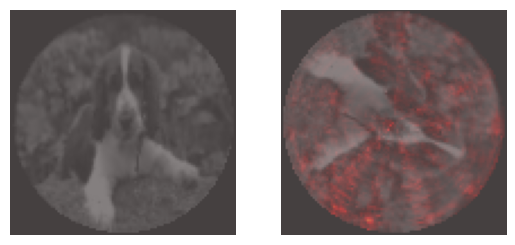

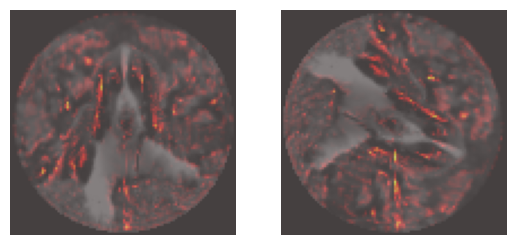

In [37]:
def saliency_map(image, model):
    image = tf.stack([image[0], tf.roll(image[0], 100, axis=1)], axis=0)
    k = tf.one_hot(tf.range(n_beams), n_beams, dtype=tf.float32)
    k = tf.transpose(k, (1, 0))
    with tf.GradientTape() as tape2:
        tape2.watch(image)
        # diag part as [batch x n_beams] @ [n_beams x n_beams(range)] = [batch x n_beams]
        # loss = tf.linalg.diag_part(1. - (model(image) @ k))
        loss = 1. - (model(image) @ k)
        # [batch x beam_len x n_beams x channels(rgb)]
        grad = tape2.gradient(loss, image)
    # max-out channels -> [batch x beam_len x n_beams]
    dgrad_max_ = np.max(tf.math.abs(grad), axis=-1)
    arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
    grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

    fig, axs = plt.subplots(1,2)
    axs[0].imshow(polar_transform_inv(image[0]), alpha=0.5)
    axs[0].imshow(plt.cm.hot(polar_transform_inv(grad_eval[0, ..., None])[..., 0]), alpha=0.5)
    axs[1].imshow(polar_transform_inv(image[1]), alpha=0.5)
    axs[1].imshow(plt.cm.hot(polar_transform_inv(grad_eval[1, ..., None])[..., 0]), alpha=0.5)
    axs[0].axis("off")
    axs[1].axis("off")
    wandb.log({"Saliency Map": fig})
    
def grad_cam(image, model): # todo test and debug
    image = tf.stack([image[0], tf.roll(image[0], 100, axis=1)], axis=0)
    with tf.GradientTape() as tape3:
        tape3.watch(image)
        preds, conv_features = model(image, output_conv_features=True)
        # class_channel = tf.gather(preds, tf.argmax(preds, axis=-1))
        class_channel = preds[:, tf.argmax(preds[0])]
    grads = tape3.gradient(class_channel, conv_features)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.squeeze(conv_features @ pooled_grads[..., None])
    print(heatmap.shape)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    fig, axs = plt.subplots(1,2)
    axs[0].imshow(polar_transform_inv(image[0]), alpha=0.5)
    axs[0].imshow(plt.cm.hot(polar_transform_inv(heatmap[0, ..., None])[..., 0]), alpha=0.5)
    axs[1].imshow(polar_transform_inv(image[1]), alpha=0.5)
    axs[1].imshow(plt.cm.hot(polar_transform_inv(heatmap[1, ..., None])[..., 0]), alpha=0.5)
    axs[0].axis("off")
    axs[1].axis("off")
    wandb.log({"Grad-CAM": fig})
    
image = next(iter(test_dataset))['polar']
saliency_map(image, model)
grad_cam(image, model)

  0%|                                                                                                                                                                                | 0/10 [00:00<?, ?it/s]

(2, 50, 314, 3)


  0%|                                                                                                                                                                                | 0/10 [00:03<?, ?it/s]


KeyboardInterrupt: 

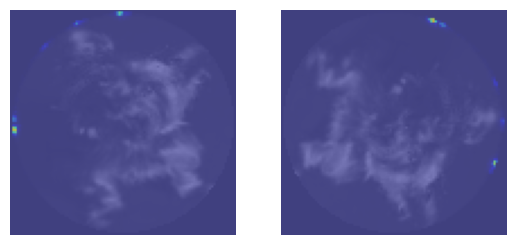

In [16]:
def roll_batch(tensor, roll_values, axis=2):
  return tf.stack([tf.roll(tensor[i], roll_values[i], axis=axis-1) for i in range(tensor.shape[0])])

# def rgb_to_rgba(rgb_array, alpha=0.5):
#   alpha_channel = np.full((rgb_array.shape[0], rgb_array.shape[1], 1), alpha, dtype=rgb_array.dtype)
#   rgba_array = np.concatenate((rgb_array, alpha_channel), axis=-1)
#   return rgba_array

def get_gt_beam_energy(epoch: int):
    # reason: the dot product dampens all signals (zero) apart from the target dimension
    sigma = 1/(epoch+1) * 10 # todo factor see experiment_lenna.ipynb
    x = tf.range(-(n_beams // 2), n_beams // 2, dtype=tf.float32)
    kernel = 1 / (sigma * tf.math.sqrt(2*math.pi)) * tf.math.exp(-x**2/(2*sigma**2))
    kernel = kernel / tf.reduce_sum(kernel)
    return kernel
    
# with strategy.scope():
true = tf.one_hot(n_beams//2, n_beams, dtype=tf.float32)
#   -> use curriculum learning by starting with Gaussian and reducing variance over time
for e in tqdm(range(n_epochs)):
    # training loop
    for s, sample in enumerate(train_dataset):
        # with strategy.scope():
        # image = polar_transform(sample['image'], radius=radius)
        image = sample['polar']
        with tf.GradientTape() as tape:
            k_distribution = model(image, training=True)
            # cosine of hyper-unit-vectors -> normalization not needed 
            loss = 1. - (k_distribution @ get_gt_beam_energy(e)[:, None]) 
            grad = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grad, model.trainable_variables))
        wandb.log({"training loss": np.mean(loss.numpy())}, step=e*len(train_dataset)+s)
        if s % 100 == 0:
            saliency_map(image, model)
            grad_cam(image, model)
        # equivariance test loop
        k = tf.random.uniform(shape=(image.shape[0],), minval=-n_beams//2, maxval=n_beams//2, dtype=tf.int64)
        image = roll_batch(image, k, axis=2)
        test_loss = tf.abs(k + n_beams//2-tf.argmax(model(image), axis=-1))
        wandb.log({"equivariance test": np.mean(test_loss.numpy())}, step=e*len(train_dataset)+s)
    # pseudo-equivariant test loop
    test_loss = []
    for s, sample in enumerate(test_dataset):
        image = sample['polar']
        # image = polar_transform(sample['image'], radius=radius)
        k = tf.random.uniform(shape=(image.shape[0],), minval=-n_beams//2, maxval=n_beams//2, dtype=tf.int64)
        image = roll_batch(image, k, axis=2)
        test_loss.append(tf.abs(k + n_beams//2-tf.argmax(model(image), axis=-1)).numpy())
    wandb.log({"testing loss": np.concatenate(test_loss, axis=0).mean()})
    model.save_weights('./model/{0}_{1}.h5'.format(dataset_name, e))

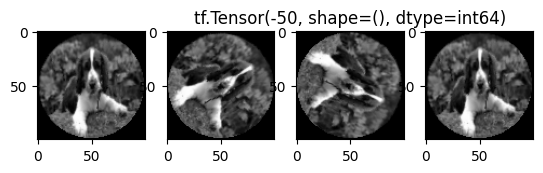

In [9]:
fig, axs = plt.subplots(1,4)
for s, sample in enumerate(test_dataset):
    image, label = sample['polar'], sample['label']
    axs[0].imshow(polar_transform_inv(image[0].numpy()))
    image = tf.roll(image, shift=50, axis=2)
    axs[1].imshow(polar_transform_inv(image[0].numpy()))
    k_distribution = model(image)
    k = tf.argmax(k_distribution, axis=-1)
    image_undo = tf.roll(image[0], shift=n_beams//2+k[0], axis=1)
    axs[2].imshow(polar_transform_inv(image_undo.numpy()))
    axs[2].set_title(n_beams//2-k[0])
    image_undo = tf.roll(image[0], shift=n_beams//2-k[0], axis=1)
    axs[3].imshow(polar_transform_inv(image_undo.numpy()))
    plt.show()
    break

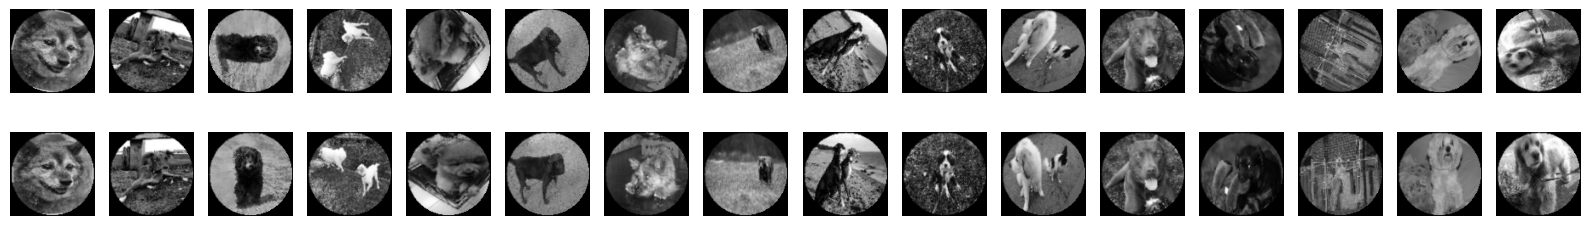

In [14]:
fig, axs = plt.subplots(2,16, figsize=(16,3))
for s, sample in enumerate(test_dataset):
    image, label = sample['polar'], sample['label']
    k = tf.random.uniform(shape=(batch_size,), 
                          minval=-n_beams//2, maxval=n_beams//2, dtype=tf.int64)
    rot_image = roll_batch(sample['polar'], k)
    k_pred = tf.argmax(model(rot_image), axis=-1)
    image_undo = roll_batch(rot_image, n_beams//2-k_pred)
    
    for i in range(16):
        axs[0, i].imshow(polar_transform_inv(rot_image[i]))
        axs[1, i].imshow(polar_transform_inv(image_undo[i]))
        axs[0, i].axis("off")
        axs[1, i].axis("off")
plt.tight_layout()